## Exploratory Data Analysis

In [53]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [54]:
analysis_df = pd.read_csv('Analysis_dataset.csv').drop('Unnamed: 0', axis = 1)

In [55]:
analysis_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


In [56]:
## Check datatypes
analysis_df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

In [58]:
## Convert signup and purchase times to 'datatime' format
analysis_df.signup_time = pd.to_datetime(analysis_df.signup_time, format = '%m/%d/%Y %H:%M')
analysis_df.purchase_time = pd.to_datetime(analysis_df.purchase_time, format = '%m/%d/%Y %H:%M')

In [57]:
## Fill missing values with NA
analysis_df = analysis_df.fillna('NA')

### Class imbalance

Text(0, 0.5, 'Number of transactions')

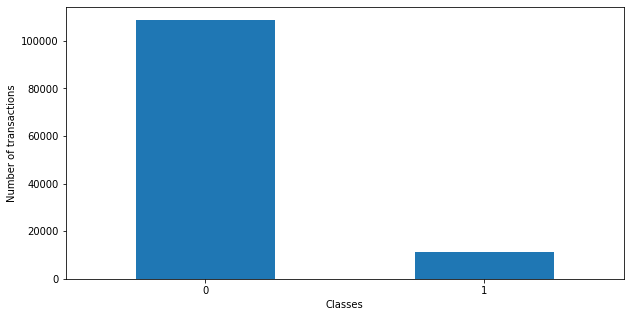

In [59]:
analysis_df['class'].value_counts()\
.plot(kind = 'bar', rot = 0, figsize = (10, 5))
plt.xlabel('Classes')
plt.ylabel('Number of transactions')

Only a few fraudulent transactions, will need to assign some sort of weight to the classification models, check recall & precision, or use cross validation to spread out the imbalance.

### New features

####  1. Time difference betweens signup and purchase

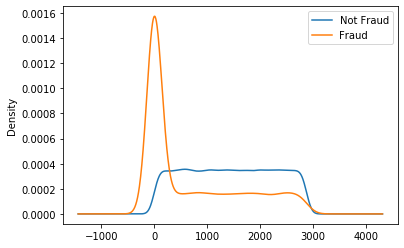

In [70]:
### Signup and purchase time difference on fraud
analysis_df['time_diff'] = (analysis_df['purchase_time'] - analysis_df['signup_time']).dt.total_seconds()/60/60 # hours
analysis_df.groupby('class')['time_diff'].plot(kind = 'kde', legend = True)
plt.legend(['Not Fraud', 'Fraud'])

#### 2. Ratio_fraud_by_country

In [60]:
## Some countries might have more fraudulent transactions than others
def calculate_ratio_fraud(df, var):
    # Group by class and the variable of interest, count unique user_ids, and expand to two columns
    temp = df.groupby([var, 'class']).user_id.nunique().unstack(level = 1).reset_index().fillna(0.0)
    # add two columns: fraud percentage and fraud amount
    temp['num_trans_' + var] = temp[1] + temp[0]
    temp['ratio_fraud_' + var] = temp[1]/temp['num_trans_' + var]
    # merge the two df
    out = analysis_df[['user_id', var]].merge(temp[[var, 'ratio_fraud_' + var, 'num_trans_' + var]], on = var)
    return(out)

In [72]:
analysis_df.groupby(['country', 'class']).user_id.nunique().unstack(level = 1).reset_index().fillna(0.0)

class,country,0,1
0,Afghanistan,4.0,1.0
1,Albania,10.0,0.0
2,Algeria,88.0,10.0
3,Angola,18.0,1.0
4,Antigua and Barbuda,2.0,0.0
...,...,...,...
172,Viet Nam,404.0,27.0
173,Virgin Islands (U.S.),1.0,1.0
174,Yemen,1.0,0.0
175,Zambia,8.0,0.0


In [61]:
calculate_ratio_fraud(analysis_df, 'country')

,user_id,country,ratio_fraud_country,num_trans_country
0,285108,United States,0.096830,46184.0
1,328855,United States,0.096830,46184.0
2,178528,United States,0.096830,46184.0
3,182104,United States,0.096830,46184.0
4,97677,United States,0.096830,46184.0
...,...,...,...,...
119995,173124,NA,0.085142,17418.0
119996,167468,NA,0.085142,17418.0
119997,379065,NA,0.085142,17418.0
119998,19916,NA,0.085142,17418.0


In [62]:
## Percentage of fraudulent transactions by country
fraud_by_country = calculate_ratio_fraud(analysis_df, 'country')
fraud_by_country.groupby(['country'])['ratio_fraud_country', 'num_trans_country'].mean().reset_index()\
.sort_values(by = 'num_trans_country', ascending = False).head(20)

,country,ratio_fraud_country,num_trans_country
167,United States,0.096830,46184.0
113,NA,0.085142,17418.0
34,China,0.085711,9532.0
82,Japan,0.096600,5735.0
166,United Kingdom,0.103911,3580.0
86,Korea Republic of,0.091589,3341.0
62,Germany,0.073010,2890.0
58,France,0.093612,2489.0
23,Brazil,0.092648,2353.0
30,Canada,0.115188,2344.0


#### 3. Ratio_fraud_by_gender

In [63]:
## Same thing for gender
fraud_by_gender = calculate_ratio_fraud(analysis_df, 'sex')
fraud_by_gender.sort_values(by = 'ratio_fraud_sex', ascending = False).groupby('sex')['ratio_fraud_sex', 'num_trans_sex'].mean().reset_index()


,sex,ratio_fraud_sex,num_trans_sex
0,F,0.091671,49874
1,M,0.095442,70126


#### 4. Ratio_fraud_by_source

In [64]:
## Same thing for source
fraud_by_source = calculate_ratio_fraud(analysis_df, 'source')
fraud_by_source.sort_values(by = 'ratio_fraud_source', ascending = False).groupby('source')['ratio_fraud_source', 'num_trans_source'].mean().reset_index()


,source,ratio_fraud_source,num_trans_source
0,Ads,0.091696,47461
1,Direct,0.105643,24242
2,SEO,0.090109,48297


#### 5. Ratio_fraud_by_browser

In [65]:
## Same thing for browser
fraud_by_browser = calculate_ratio_fraud(analysis_df, 'browser')
fraud_by_browser.sort_values(by = 'ratio_fraud_browser', ascending = False).groupby('browser')['ratio_fraud_browser', 'num_trans_browser'].mean().reset_index()


,browser,ratio_fraud_browser,num_trans_browser
0,Chrome,0.099441,48652
1,FireFox,0.094112,19615
2,IE,0.086107,29138
3,Opera,0.091429,2975
4,Safari,0.091743,19620


#### 6. Ratio_fraud_by_age

In [66]:
## Same for age
fraud_by_age = calculate_ratio_fraud(analysis_df, 'age')
fraud_by_age.sort_values(by = 'ratio_fraud_age', ascending = False).groupby('age')['ratio_fraud_age', 'num_trans_age'].mean().head(20)


,ratio_fraud_age,num_trans_age
age,,
18,0.097639,2202.0
19,0.086147,2310.0
20,0.089647,2666.0
21,0.079291,2989.0
22,0.092587,3251.0
23,0.108641,3599.0
24,0.100889,3935.0
25,0.078928,4143.0
26,0.076906,4460.0
